In [1]:
import torchtext
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext.legacy import data, datasets
from torchtext.vocab import GloVe
from sklearn.model_selection import train_test_split
import torch.optim as optim
import time
import pickle
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction import stop_words
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt  
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score
from tqdm import tqdm
from matplotlib.gridspec import GridSpec
import math
import string
import numpy as np
import seaborn as sns

from sklearn.metrics import confusion_matrix
stopwords = stop_words.ENGLISH_STOP_WORDS

def clean(doc): # doc is a string of text
    doc = doc.replace("</br>", " ") # This text contains a lot of <br/> tags.
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    doc = " ".join([token for token in doc.split() if token not in stopwords])
    # remove punctuation and numbers
    return doc


def get_dataset(X, y, text_field, label_field, test=False):
    fields = [('id', None), ('text', text_field), ('label', label_field)]
    examples = []
    for text, label in zip(X, y.tolist()):
        examples.append(data.Example.fromlist([None, clean(text), label], fields))
    return examples, fields


TEXT = data.Field(batch_first=True, lower=True, tokenize="spacy")
LABEL = data.Field(sequential=False)
glove_vectors = GloVe(name='6B', dim=100)
newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')
cats = list(newsgroups_train.target_names)


X_train, X_val, y_train, y_val = train_test_split(newsgroups_train.data, newsgroups_train.target, test_size=0.25, random_state=42)
train_examples, train_fields = get_dataset(X_train, y_train, TEXT, LABEL)
val_examples, val_fields = get_dataset(X_val, y_val, TEXT, LABEL)
test_examples, test_fields = get_dataset(newsgroups_test.data, newsgroups_test.target, TEXT, LABEL)


train = data.Dataset(train_examples, train_fields)
val = data.Dataset(val_examples, val_fields)
test = data.Dataset(test_examples, test_fields)

# glove_stoi_path = "vocab_label_stoi.pkl"
# pickle.dump([TEXT.vocab.stoi, LABEL.vocab.stoi], open(glove_stoi_path, "wb"))

TEXT.build_vocab(train, val, test, vectors=glove_vectors)
LABEL.build_vocab(train)
num_words = int(TEXT.vocab.vectors.size()[0])

batch_sz = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_iter, val_iter, test_iter = data.BucketIterator.splits(
    datasets=(train, val, test),
    batch_sizes=(batch_sz, batch_sz, 1),
    shuffle=True,
    device=device,
    sort=False
)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)
.vector_cache/glove.6B.zip: 862MB [02:41, 5.34MB/s]                           
100%|█████████▉| 399999/400000 [00:14<00:00, 27116.93it/s]


In [2]:
class FastText(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, pad_idx):    
        super().__init__()   
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)   
        self.fc = nn.Linear(embedding_dim, output_dim)
        
    def forward(self, text):
        #text = [sent len, batch size]
        embedded = self.embedding(text.T)
        embedded = embedded.permute(1, 0, 2)
        pooled = F.avg_pool2d(embedded, (embedded.shape[1], 1)).squeeze(1)
        return self.fc(pooled)


class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        self.conv_0 = nn.Conv2d(in_channels = 1, 
                                out_channels = n_filters, 
                                kernel_size = (filter_sizes[0], embedding_dim))
        self.conv_1 = nn.Conv2d(in_channels = 1, 
                                out_channels = n_filters, 
                                kernel_size = (filter_sizes[1], embedding_dim))
        self.conv_2 = nn.Conv2d(in_channels = 1, 
                                out_channels = n_filters, 
                                kernel_size = (filter_sizes[2], embedding_dim))
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)  
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        embedded = self.embedding(text)
        embedded = embedded.unsqueeze(1)      
        conved_0 = F.relu(self.conv_0(embedded).squeeze(3))
        conved_1 = F.relu(self.conv_1(embedded).squeeze(3))
        conved_2 = F.relu(self.conv_2(embedded).squeeze(3))       
        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1, conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2, conved_2.shape[2]).squeeze(2)      
        cat = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim = 1))       
        return self.fc(cat)


def train(model, iterator, optimizer, criterion):
  epoch_loss = 0
  model.train()
  for batch in iterator:    
      optimizer.zero_grad()
      predictions = model(batch.text)
      loss = criterion(predictions.squeeze(1), batch.label-1)
      loss.backward()
      optimizer.step()
      epoch_loss += loss.item()
  return epoch_loss / len(iterator)


def evaluate(model, iterator, criterion):
  epoch_loss = 0
  model.eval()
  with torch.no_grad():
      for batch in iterator:
          predictions = model(batch.text)
          loss = criterion(predictions.squeeze(1), batch.label-1)
          epoch_loss += loss.item()
  return epoch_loss / len(iterator)


def test(model, iterator):
  model.eval()
  predict = []
  gt = []
  with torch.no_grad():
      for batch in iterator:
        predictions = model(batch.text)
        predictions_ = np.argmax(nn.Softmax(dim=1)(predictions.squeeze(1)).cpu().numpy())
        predict.append(predictions_+1)
        gt.append(batch.label.item())
  return predict, gt

In [3]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
OUTPUT_DIM = 20
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

N_EPOCHS = 5
best_valid_loss = float('inf')
rnn_model = FastText(INPUT_DIM, EMBEDDING_DIM, OUTPUT_DIM, PAD_IDX)
pretrained_embeddings = TEXT.vocab.vectors
rnn_model.embedding.weight.data.copy_(pretrained_embeddings)
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
rnn_model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
rnn_model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)


optimizer = optim.Adam(rnn_model.parameters(), lr=0.008)
criterion = nn.CrossEntropyLoss()
rnn_model = rnn_model.to(device)
criterion = criterion.to(device)
for epoch in range(N_EPOCHS):
    train_loss = train(rnn_model, train_iter, optimizer, criterion)
    valid_loss = evaluate(rnn_model, val_iter, criterion)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(rnn_model.state_dict(), 'rnn.pt')
    print('train loss:\t%f'%train_loss, '\tvalid loss:\t%f'%valid_loss, )

train loss:	2.702216 	valid loss:	2.278113
train loss:	1.913338 	valid loss:	1.622916
train loss:	1.311090 	valid loss:	1.171968
train loss:	0.955922 	valid loss:	0.950628
train loss:	0.684398 	valid loss:	0.765746


In [4]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [3,4,5]
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

cnn_model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
pretrained_embeddings = TEXT.vocab.vectors
cnn_model.embedding.weight.data.copy_(pretrained_embeddings)
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
cnn_model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
cnn_model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)


optimizer = optim.Adam(cnn_model.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()
cnn_model = cnn_model.to(device)
criterion = criterion.to(device)


for epoch in range(N_EPOCHS):
    train_loss = train(cnn_model, train_iter, optimizer, criterion)
    valid_loss = evaluate(cnn_model, val_iter, criterion)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(cnn_model.state_dict(), 'cnn.pt')
    print('train loss:\t%f'%train_loss, '\tvalid loss:\t%f'%valid_loss, )

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


train loss:	1.694200 	valid loss:	0.741499
train loss:	0.662312 	valid loss:	0.505620
train loss:	0.303452 	valid loss:	0.415132
train loss:	0.149847 	valid loss:	0.397478
train loss:	0.077932 	valid loss:	0.394912


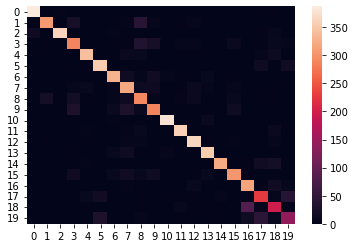

macro F1 score:	0.822349	micro F1 score:	0.829395


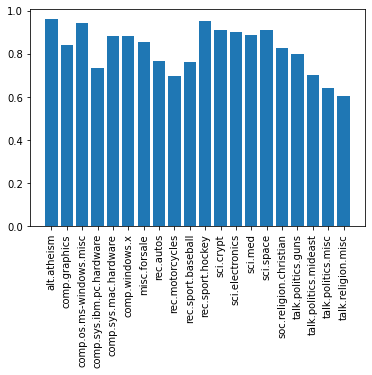

In [5]:
cat_dic = {}
for (a,b) in zip(fetch_20newsgroups(subset='train')['target'], fetch_20newsgroups(subset='train')['target_names']):
  cat_dic[a] = b

rnn_pre, rnn_gt = test(rnn_model, test_iter)
confusion_m = confusion_matrix(rnn_gt, rnn_pre)
ax = sns.heatmap(confusion_m)
plt.show()

macro_s = f1_score(rnn_gt, rnn_pre, average='macro')
micro_s = f1_score(rnn_gt, rnn_pre, average='micro')
print('macro F1 score:\t%f\tmicro F1 score:\t%f'%(macro_s,micro_s))

plt.bar(list(range(len(cats))), f1_score(rnn_gt, rnn_pre, average=None))
plt.xticks(list(range(len(cats))), labels=cats, rotation=90)
plt.show()


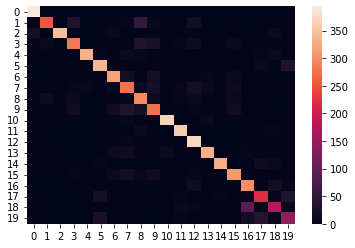

macro F1 score:	0.796976	micro F1 score:	0.804434
alt.atheism 0.933649289099526
comp.graphics 0.7485380116959065
comp.os.ms-windows.misc 0.9220607661822986
comp.sys.ibm.pc.hardware 0.753004005340454
comp.sys.mac.hardware 0.8906666666666667
comp.windows.x 0.8430160692212609
misc.forsale 0.8106734434561627
rec.autos 0.6881987577639752
rec.motorcycles 0.7069988137603795
rec.sport.baseball 0.7040816326530612
rec.sport.hockey 0.9259723964868257
sci.crypt 0.8927250308261405
sci.electronics 0.8465011286681716
sci.med 0.8804204993429697
sci.space 0.9120879120879122
soc.religion.christian 0.8103896103896104
talk.politics.guns 0.753731343283582
talk.politics.mideast 0.7006369426751593
talk.politics.misc 0.6206896551724138
talk.religion.misc 0.5954825462012321


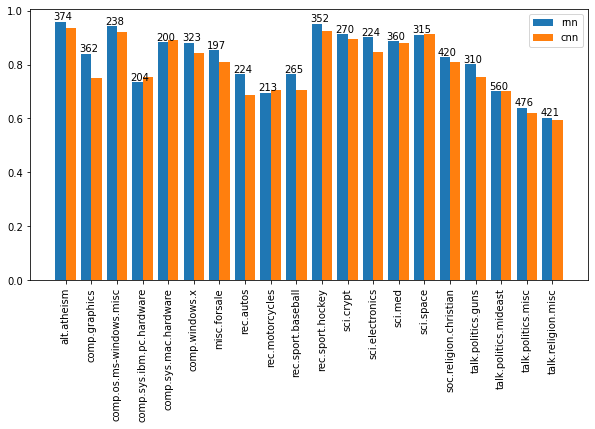

In [6]:
cnn_pre, cnn_gt = test(cnn_model, test_iter)
confusion_m = confusion_matrix(cnn_gt, cnn_pre)
ax = sns.heatmap(confusion_m)
plt.show()

plt.figure(figsize=(10,5))
macro_s = f1_score(cnn_gt, cnn_pre, average='macro')
micro_s = f1_score(cnn_gt, cnn_pre, average='micro')
print('macro F1 score:\t%f\tmicro F1 score:\t%f'%(macro_s,micro_s))
plt.bar(np.array(range(len(cats)))-0.2, f1_score(rnn_gt, rnn_pre, average=None), width=0.4, label='rnn')
plt.bar(np.array(range(len(cats)))+0.2, f1_score(cnn_gt, cnn_pre, average=None), width=0.4, label='cnn')
plt.xticks(list(range(len(cats))), labels=cats, rotation=90)
plt.legend()
for i in range(20):
  print(cats[i], f1_score(cnn_gt, cnn_pre, average=None)[i])


lens = {}
for _i in range(20):
  lens[_i] = [] 
for _idx, _i in enumerate(newsgroups_test.target):
  lens[_i].append(len(newsgroups_test.data[_idx].split(' ')))
for _i in range(20):
  lens[_i] = sum(lens[_i])/len(lens[_i])

for _idx,(x,y) in enumerate(zip(np.array(range(len(cats)))-0.2,f1_score(rnn_gt, rnn_pre, average=None))):
    plt.text(x+0.1,y,'%i' %int(lens[_idx]), ha='center',va='bottom')
plt.show()

In [7]:

print(lens)

{0: 374.5830721003135, 1: 362.5629820051414, 2: 238.88324873096445, 3: 204.4234693877551, 4: 200.46233766233766, 5: 323.6759493670886, 6: 197.65641025641025, 7: 224.4469696969697, 8: 213.3894472361809, 9: 265.9874055415617, 10: 352.74436090225566, 11: 270.55555555555554, 12: 224.3587786259542, 13: 360.14646464646466, 14: 315.5406091370558, 15: 420.54020100502515, 16: 310.5274725274725, 17: 560.0, 18: 476.60967741935485, 19: 421.2589641434263}


In [9]:
cat1 = 'talk.politics.misc'
cat2 = 'talk.religion.misc'
cat_dic = {}
# for cat in cats:
#   data1 = fetch_20newsgroups(subset='train', categories=[cat])
#   cat_dic[cat] = data1.target
newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')
cats = list(newsgroups_train.target_names)



In [10]:
print(cat_dic)

{}


In [11]:
class FastText_LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, pad_idx):    
        super().__init__()   
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)   
        self.fc = nn.Linear(60, output_dim)
        self.lstm = nn.LSTM(100, 60, 2, dropout=0.2)
        
    def forward(self, text):
        #text = [sent len, batch size]
        embedded = self.embedding(text.T)
        embedded, (h, c) = self.lstm(embedded)
        embedded = embedded.permute(1, 0, 2)
        pooled = F.avg_pool2d(embedded, (embedded.shape[1], 1)).squeeze(1)
        return self.fc(pooled)

In [12]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
OUTPUT_DIM = 20
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

N_EPOCHS = 10
best_valid_loss = float('inf')
rnn_model = FastText_LSTM(INPUT_DIM, EMBEDDING_DIM, OUTPUT_DIM, PAD_IDX)
pretrained_embeddings = TEXT.vocab.vectors
rnn_model.embedding.weight.data.copy_(pretrained_embeddings)
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
rnn_model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
rnn_model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)


optimizer = optim.Adam(rnn_model.parameters(), lr=0.015)
criterion = nn.CrossEntropyLoss()
rnn_model = rnn_model.to(device)
criterion = criterion.to(device)
for epoch in range(N_EPOCHS):
    torch.cuda.empty_cache()
    train_loss = train(rnn_model, train_iter, optimizer, criterion)
    valid_loss = evaluate(rnn_model, val_iter, criterion)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(rnn_model.state_dict(), 'rnn.pt')
    print('train loss:\t%f'%train_loss, '\tvalid loss:\t%f'%valid_loss, )

train loss:	2.698150 	valid loss:	2.358785
train loss:	2.062667 	valid loss:	1.797732
train loss:	1.595741 	valid loss:	1.471932
train loss:	1.249215 	valid loss:	1.257105
train loss:	0.860053 	valid loss:	1.108400
train loss:	0.737563 	valid loss:	1.184770
train loss:	0.718093 	valid loss:	1.332152
train loss:	0.588379 	valid loss:	1.090557
train loss:	0.358181 	valid loss:	0.935725
train loss:	0.223647 	valid loss:	0.964537


train loss:	2.640059 	valid loss:	2.427331
train loss:	2.248223 	valid loss:	2.026034
train loss:	1.684953 	valid loss:	1.689623
train loss:	1.298723 	valid loss:	1.542843
train loss:	1.047423 	valid loss:	1.414708
train loss:	0.737093 	valid loss:	1.236895
train loss:	0.543297 	valid loss:	1.252681
train loss:	0.383901 	valid loss:	1.247214
train loss:	0.308507 	valid loss:	1.290793
train loss:	0.237016 	valid loss:	1.272344


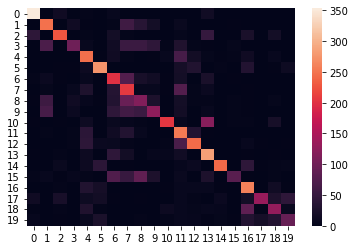

macro F1 score:	0.530525	micro F1 score:	0.535183


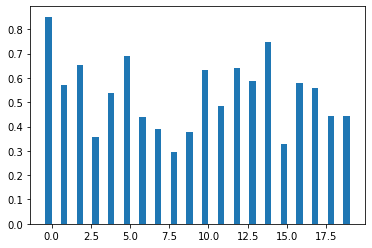

train loss:	2.544105 	valid loss:	2.112891
train loss:	2.024233 	valid loss:	1.883399
train loss:	1.690078 	valid loss:	1.793862
train loss:	1.456898 	valid loss:	1.564830
train loss:	1.159163 	valid loss:	1.400205
train loss:	0.923632 	valid loss:	1.312428
train loss:	0.725666 	valid loss:	1.192423
train loss:	0.571948 	valid loss:	1.114796
train loss:	0.451923 	valid loss:	1.138734
train loss:	0.346811 	valid loss:	1.159813


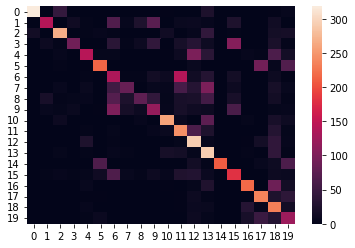

macro F1 score:	0.512601	micro F1 score:	0.515401


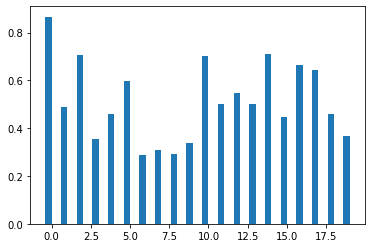

train loss:	2.531378 	valid loss:	2.256837
train loss:	1.976900 	valid loss:	1.971193
train loss:	1.671930 	valid loss:	1.808343
train loss:	1.490959 	valid loss:	1.550151
train loss:	1.247365 	valid loss:	1.432851
train loss:	1.027724 	valid loss:	1.287926
train loss:	0.853247 	valid loss:	1.242283
train loss:	0.680476 	valid loss:	1.193936
train loss:	0.528223 	valid loss:	1.152060
train loss:	0.412708 	valid loss:	1.235230


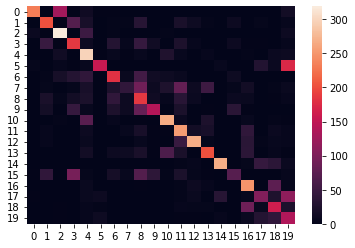

macro F1 score:	0.512220	micro F1 score:	0.522172


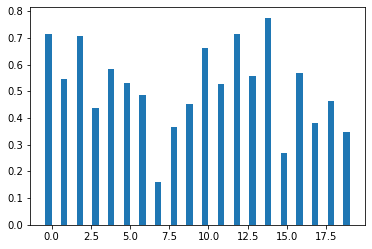

train loss:	2.914873 	valid loss:	2.470170
train loss:	2.231942 	valid loss:	2.066576
train loss:	1.846235 	valid loss:	1.791947
train loss:	1.517478 	valid loss:	1.739235
train loss:	1.189208 	valid loss:	1.510856
train loss:	0.909107 	valid loss:	1.313606
train loss:	0.745192 	valid loss:	1.244839
train loss:	0.570760 	valid loss:	1.385553
train loss:	0.554925 	valid loss:	1.235753
train loss:	0.412299 	valid loss:	1.173404


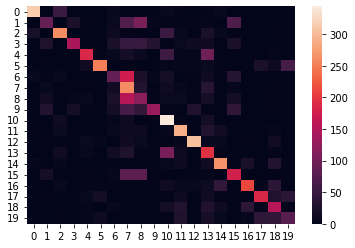

macro F1 score:	0.539729	micro F1 score:	0.540627


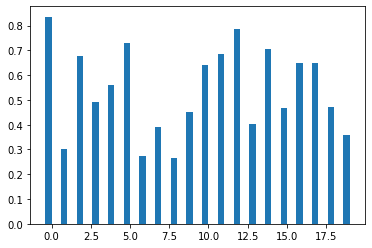

train loss:	2.667856 	valid loss:	2.310007
train loss:	2.306633 	valid loss:	2.091776
train loss:	1.816571 	valid loss:	1.703613
train loss:	1.388180 	valid loss:	1.435679
train loss:	0.970537 	valid loss:	1.227945
train loss:	0.734187 	valid loss:	1.107759
train loss:	0.505295 	valid loss:	1.082492
train loss:	0.391900 	valid loss:	0.965871
train loss:	0.245504 	valid loss:	1.004418
train loss:	0.191804 	valid loss:	1.007276


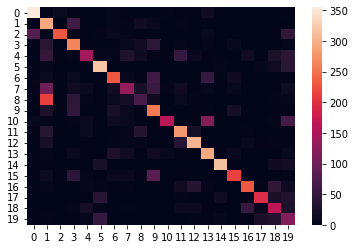

macro F1 score:	0.602970	micro F1 score:	0.607541


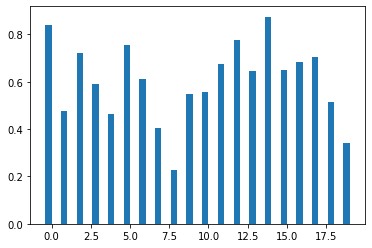

train loss:	2.557362 	valid loss:	2.349054
train loss:	1.928012 	valid loss:	1.509702
train loss:	1.496085 	valid loss:	1.424403
train loss:	0.985826 	valid loss:	1.089632
train loss:	0.601233 	valid loss:	1.004757
train loss:	0.381621 	valid loss:	0.921038
train loss:	0.246893 	valid loss:	0.917630
train loss:	0.204692 	valid loss:	0.924390
train loss:	0.143137 	valid loss:	0.897782
train loss:	0.088912 	valid loss:	0.938475


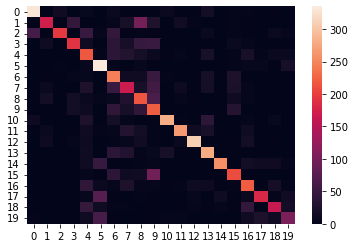

macro F1 score:	0.613003	micro F1 score:	0.607674


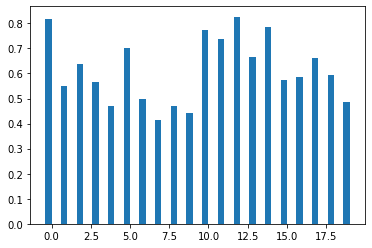

train loss:	2.595105 	valid loss:	2.406114
train loss:	1.981607 	valid loss:	1.953884
train loss:	1.597857 	valid loss:	1.578313
train loss:	1.171255 	valid loss:	1.290701
train loss:	0.833207 	valid loss:	1.343126
train loss:	0.686984 	valid loss:	1.239221
train loss:	0.470076 	valid loss:	1.284632
train loss:	0.351790 	valid loss:	1.223265
train loss:	0.298401 	valid loss:	1.182163
train loss:	0.239083 	valid loss:	1.194250


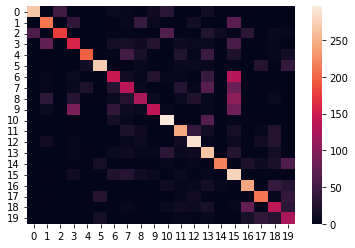

macro F1 score:	0.549752	micro F1 score:	0.548460


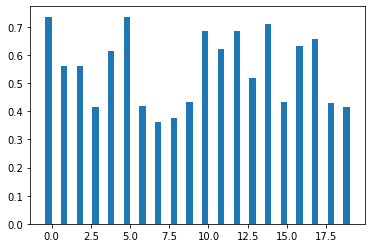

train loss:	2.600830 	valid loss:	2.476511
train loss:	2.153543 	valid loss:	2.209003
train loss:	1.675171 	valid loss:	1.723234
train loss:	1.296766 	valid loss:	1.574875
train loss:	0.966242 	valid loss:	1.424916
train loss:	0.702473 	valid loss:	1.067624
train loss:	0.428039 	valid loss:	1.080299
train loss:	0.301269 	valid loss:	1.000299
train loss:	0.212971 	valid loss:	1.021874
train loss:	0.152127 	valid loss:	1.089952


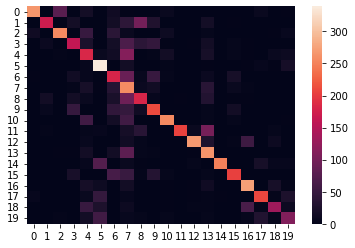

macro F1 score:	0.595359	micro F1 score:	0.581386


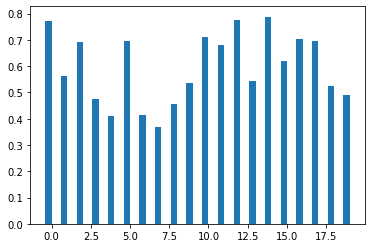

train loss:	2.876629 	valid loss:	2.585082
train loss:	2.379788 	valid loss:	2.437318
train loss:	2.096651 	valid loss:	2.004850
train loss:	1.707161 	valid loss:	1.822165
train loss:	1.478674 	valid loss:	1.750454
train loss:	1.236746 	valid loss:	1.532522
train loss:	0.975004 	valid loss:	1.454501
train loss:	0.822775 	valid loss:	1.505042
train loss:	0.728927 	valid loss:	1.349996
train loss:	0.589492 	valid loss:	1.280121


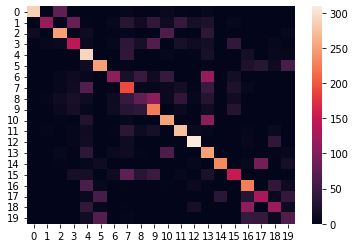

macro F1 score:	0.514672	micro F1 score:	0.524429


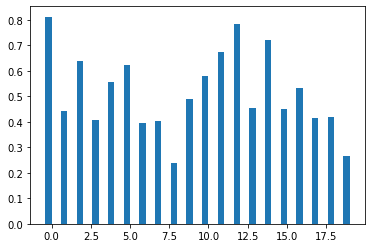

train loss:	2.644969 	valid loss:	2.470178
train loss:	2.271342 	valid loss:	2.211838
train loss:	1.847269 	valid loss:	1.680720
train loss:	1.280018 	valid loss:	1.318826
train loss:	0.909393 	valid loss:	1.305684
train loss:	0.683656 	valid loss:	1.117650
train loss:	0.487872 	valid loss:	1.108494
train loss:	0.363745 	valid loss:	1.042269
train loss:	0.255828 	valid loss:	1.107138
train loss:	0.194908 	valid loss:	1.044453


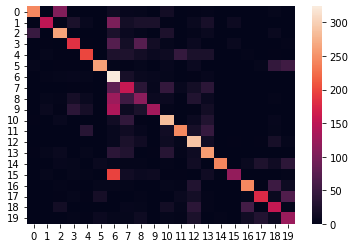

macro F1 score:	0.561111	micro F1 score:	0.554567


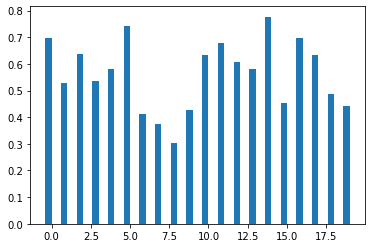

In [18]:
for i in range(10):
  INPUT_DIM = len(TEXT.vocab)
  EMBEDDING_DIM = 100
  OUTPUT_DIM = 20
  PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

  N_EPOCHS = 10
  best_valid_loss = float('inf')
  rnn_model = FastText_LSTM(INPUT_DIM, EMBEDDING_DIM, OUTPUT_DIM, PAD_IDX)
  pretrained_embeddings = TEXT.vocab.vectors
  rnn_model.embedding.weight.data.copy_(pretrained_embeddings)
  UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
  rnn_model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
  rnn_model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)


  optimizer = optim.Adam(rnn_model.parameters(), lr=0.015)
  criterion = nn.CrossEntropyLoss()
  rnn_model = rnn_model.to(device)
  criterion = criterion.to(device)
  for epoch in range(N_EPOCHS):
      torch.cuda.empty_cache()
      train_loss = train(rnn_model, train_iter, optimizer, criterion)
      valid_loss = evaluate(rnn_model, val_iter, criterion)
      if valid_loss < best_valid_loss:
          best_valid_loss = valid_loss
          torch.save(rnn_model.state_dict(), 'rnn.pt')
      print('train loss:\t%f'%train_loss, '\tvalid loss:\t%f'%valid_loss, )








  cat_dic = {}
  for (a,b) in zip(fetch_20newsgroups(subset='train')['target'], fetch_20newsgroups(subset='train')['target_names']):
    cat_dic[a] = b

  rnn_pre, rnn_gt = test(rnn_model, test_iter)
  confusion_m = confusion_matrix(rnn_gt, rnn_pre)
  ax = sns.heatmap(confusion_m)
  plt.show()

  macro_s = f1_score(rnn_gt, rnn_pre, average='macro')
  micro_s = f1_score(rnn_gt, rnn_pre, average='micro')
  print('macro F1 score:\t%f\tmicro F1 score:\t%f'%(macro_s,micro_s))

  plt.figure()
  plt.bar(np.array(range(len(cats)))-0.2, f1_score(rnn_gt, rnn_pre, average=None), width=0.4, label='lstm')
  plt.show()

In [ ]:
for _idx,(x,y) in enumerate(zip(np.array(range(len(cats)))-0.2,f1_score(rnn_gt, rnn_pre, average=None))):
    plt.text(x+0.1,y,'%i' %int(lens[_idx]), ha='center',va='bottom')
plt.show()

In [ ]:
macro F1 score:	0.530525	micro F1 score:	0.535183
macro F1 score:	0.512601	micro F1 score:	0.515401
macro F1 score:	0.512220	micro F1 score:	0.522172
macro F1 score:	0.539729	micro F1 score:	0.540627
macro F1 score:	0.602970	micro F1 score:	0.607541
macro F1 score:	0.613003	micro F1 score:	0.607674
macro F1 score:	0.549752	micro F1 score:	0.548460
macro F1 score:	0.595359	micro F1 score:	0.581386
macro F1 score:	0.514672	micro F1 score:	0.524429
macro F1 score:	0.561111	micro F1 score:	0.554567





train loss:	1.706943 	valid loss:	0.794710
train loss:	0.667741 	valid loss:	0.500497
train loss:	0.322204 	valid loss:	0.414761
train loss:	0.150209 	valid loss:	0.386631
train loss:	0.069273 	valid loss:	0.401107


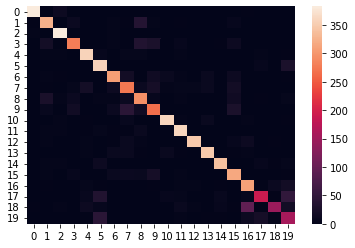

macro F1 score:	0.802131	micro F1 score:	0.811604
alt.atheism 0.9622166246851387
comp.graphics 0.8104738154613467
comp.os.ms-windows.misc 0.9296116504854368
comp.sys.ibm.pc.hardware 0.7643835616438356
comp.sys.mac.hardware 0.8774509803921569
comp.windows.x 0.8239355581127733
misc.forsale 0.8047182175622541
rec.autos 0.6926952141057934
rec.motorcycles 0.7232472324723248
rec.sport.baseball 0.7017082785808147
rec.sport.hockey 0.9104665825977302
sci.crypt 0.8880688806888067
sci.electronics 0.9198423127463863
sci.med 0.89602053915276
sci.space 0.9214092140921409
soc.religion.christian 0.7836835599505563
talk.politics.guns 0.7616707616707618
talk.politics.mideast 0.6869409660107335
talk.politics.misc 0.6074380165289256
talk.religion.misc 0.5766423357664234


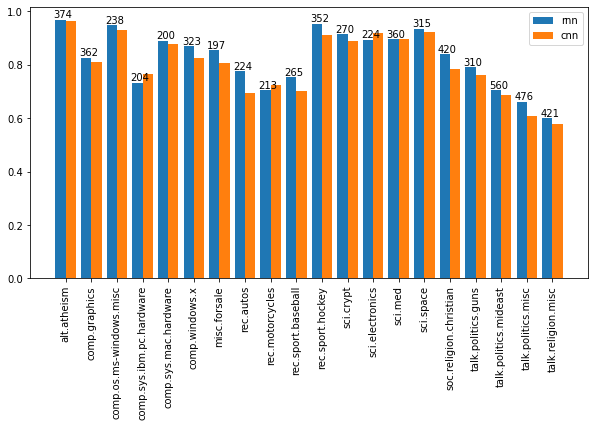

train loss:	1.707544 	valid loss:	0.762183
train loss:	0.652795 	valid loss:	0.492936
train loss:	0.310594 	valid loss:	0.432157
train loss:	0.150505 	valid loss:	0.395488
train loss:	0.082304 	valid loss:	0.408974


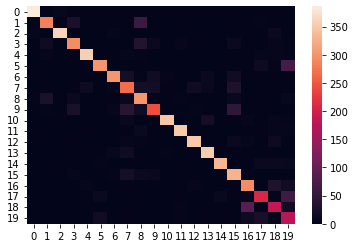

macro F1 score:	0.797135	micro F1 score:	0.802310
alt.atheism 0.9601990049751243
comp.graphics 0.7675675675675675
comp.os.ms-windows.misc 0.9295774647887324
comp.sys.ibm.pc.hardware 0.7722513089005235
comp.sys.mac.hardware 0.9072426937738246
comp.windows.x 0.8200270635994588
misc.forsale 0.8240109140518418
rec.autos 0.6708385481852315
rec.motorcycles 0.6988505747126437
rec.sport.baseball 0.6961483594864478
rec.sport.hockey 0.9131578947368422
sci.crypt 0.8991060025542784
sci.electronics 0.8976982097186701
sci.med 0.8808933002481389
sci.space 0.9150684931506848
soc.religion.christian 0.7764705882352942
talk.politics.guns 0.7477820025348543
talk.politics.mideast 0.7009966777408637
talk.politics.misc 0.607843137254902
talk.religion.misc 0.5569620253164557


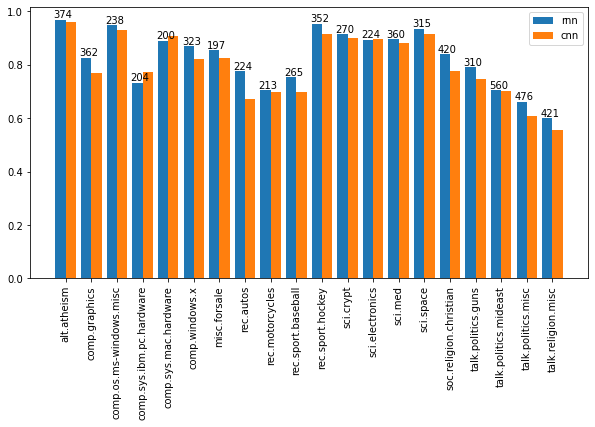

train loss:	1.714046 	valid loss:	0.767408
train loss:	0.665714 	valid loss:	0.486103
train loss:	0.317276 	valid loss:	0.401364
train loss:	0.146634 	valid loss:	0.397243
train loss:	0.072068 	valid loss:	0.390653


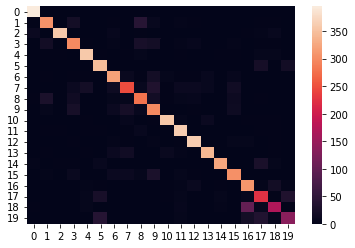

macro F1 score:	0.802001	micro F1 score:	0.810674
alt.atheism 0.959902794653706
comp.graphics 0.7906976744186046
comp.os.ms-windows.misc 0.9312581063553825
comp.sys.ibm.pc.hardware 0.7573062261753495
comp.sys.mac.hardware 0.8872366790582404
comp.windows.x 0.8355342136854742
misc.forsale 0.8173690932311621
rec.autos 0.6831955922865014
rec.motorcycles 0.7163029525032093
rec.sport.baseball 0.7187500000000001
rec.sport.hockey 0.9121019108280255
sci.crypt 0.8778718258766626
sci.electronics 0.8974042027194066
sci.med 0.8891786179921773
sci.space 0.9015256588072122
soc.religion.christian 0.8
talk.politics.guns 0.7579462102689487
talk.politics.mideast 0.676737160120846
talk.politics.misc 0.6265938069216758
talk.religion.misc 0.6031042128603104


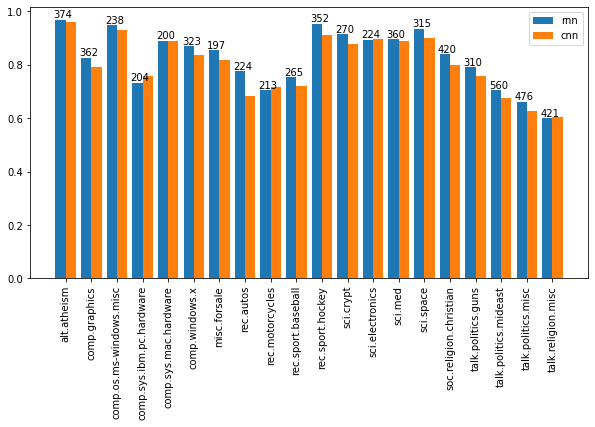

train loss:	1.712620 	valid loss:	0.758702
train loss:	0.668714 	valid loss:	0.501405
train loss:	0.318210 	valid loss:	0.427764
train loss:	0.140470 	valid loss:	0.400342
train loss:	0.067680 	valid loss:	0.404297


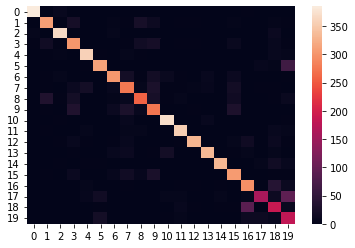

macro F1 score:	0.791448	micro F1 score:	0.797929
alt.atheism 0.9661229611041405
comp.graphics 0.7974193548387096
comp.os.ms-windows.misc 0.9246231155778893
comp.sys.ibm.pc.hardware 0.7441285537700866
comp.sys.mac.hardware 0.8853267570900124
comp.windows.x 0.8252299605781866
misc.forsale 0.8101604278074868
rec.autos 0.6969696969696969
rec.motorcycles 0.7117241379310345
rec.sport.baseball 0.685
rec.sport.hockey 0.9073170731707317
sci.crypt 0.8978562421185372
sci.electronics 0.8912751677852349
sci.med 0.8827404479578392
sci.space 0.919889502762431
soc.religion.christian 0.7688442211055277
talk.politics.guns 0.7412060301507536
talk.politics.mideast 0.6313725490196077
talk.politics.misc 0.5855161787365177
talk.religion.misc 0.5562310030395137


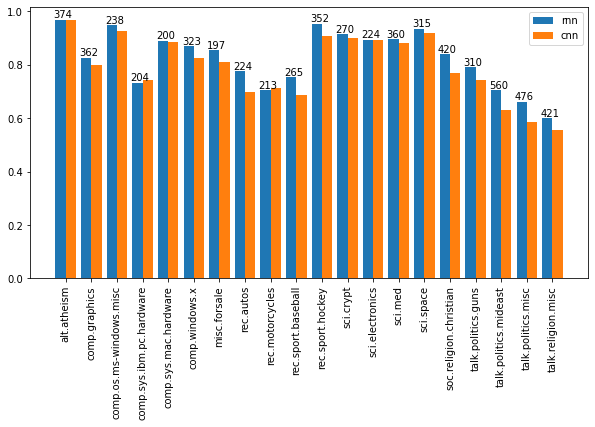

train loss:	1.719786 	valid loss:	0.805158
train loss:	0.680682 	valid loss:	0.528237
train loss:	0.324508 	valid loss:	0.422006
train loss:	0.145028 	valid loss:	0.398475
train loss:	0.077960 	valid loss:	0.412617


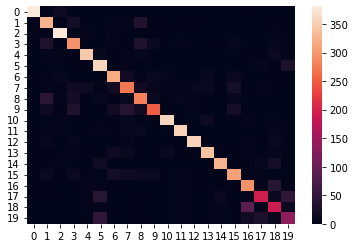

macro F1 score:	0.799042	micro F1 score:	0.807223
alt.atheism 0.9657794676806083
comp.graphics 0.7710557532621589
comp.os.ms-windows.misc 0.9161603888213852
comp.sys.ibm.pc.hardware 0.7452948557089084
comp.sys.mac.hardware 0.8923076923076922
comp.windows.x 0.8108108108108109
misc.forsale 0.7969924812030074
rec.autos 0.7045161290322581
rec.motorcycles 0.6972704714640198
rec.sport.baseball 0.723342939481268
rec.sport.hockey 0.9220945083014049
sci.crypt 0.9083969465648855
sci.electronics 0.9175257731958762
sci.med 0.8854166666666665
sci.space 0.8983516483516484
soc.religion.christian 0.8057742782152231
talk.politics.guns 0.7531806615776082
talk.politics.mideast 0.691358024691358
talk.politics.misc 0.6073131955484896
talk.religion.misc 0.5679012345679012


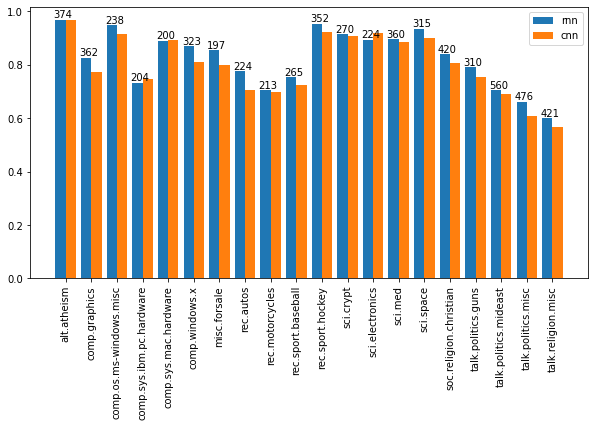

train loss:	1.704625 	valid loss:	0.814641
train loss:	0.655973 	valid loss:	0.549436
train loss:	0.311460 	valid loss:	0.423973
train loss:	0.132933 	valid loss:	0.392874
train loss:	0.078479 	valid loss:	0.408580


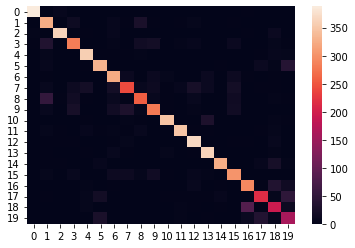

macro F1 score:	0.798614	micro F1 score:	0.806028
alt.atheism 0.968789013732834
comp.graphics 0.755813953488372
comp.os.ms-windows.misc 0.9272030651340997
comp.sys.ibm.pc.hardware 0.7421052631578947
comp.sys.mac.hardware 0.8820638820638821
comp.windows.x 0.8394437420986093
misc.forsale 0.7970479704797049
rec.autos 0.6741258741258741
rec.motorcycles 0.7079889807162535
rec.sport.baseball 0.7479892761394102
rec.sport.hockey 0.9003880983182407
sci.crypt 0.9041450777202072
sci.electronics 0.8796185935637664
sci.med 0.8799999999999999
sci.space 0.9055555555555556
soc.religion.christian 0.7819354838709678
talk.politics.guns 0.762402088772846
talk.politics.mideast 0.7140495867768594
talk.politics.misc 0.6129541864139022
talk.religion.misc 0.5886654478976234


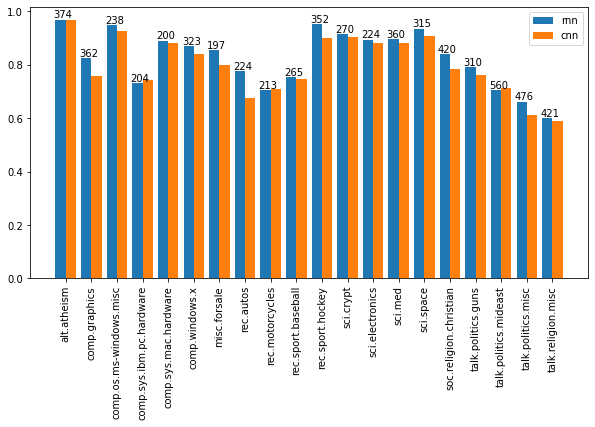

train loss:	1.725197 	valid loss:	0.771345
train loss:	0.658289 	valid loss:	0.511626
train loss:	0.334278 	valid loss:	0.430516
train loss:	0.143591 	valid loss:	0.417549
train loss:	0.069233 	valid loss:	0.424382


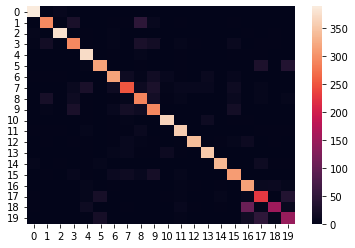

macro F1 score:	0.801174	micro F1 score:	0.810143
alt.atheism 0.94993894993895
comp.graphics 0.7850467289719625
comp.os.ms-windows.misc 0.9460476787954829
comp.sys.ibm.pc.hardware 0.7571059431524547
comp.sys.mac.hardware 0.8664343786295007
comp.windows.x 0.8233766233766233
misc.forsale 0.8170103092783505
rec.autos 0.6886145404663924
rec.motorcycles 0.7057387057387057
rec.sport.baseball 0.7252475247524752
rec.sport.hockey 0.912718204488778
sci.crypt 0.8817733990147784
sci.electronics 0.9059602649006623
sci.med 0.8953341740226988
sci.space 0.9205479452054796
soc.religion.christian 0.8020698576972833
talk.politics.guns 0.7577937649880095
talk.politics.mideast 0.6745913818722139
talk.politics.misc 0.6153846153846153
talk.religion.misc 0.5927419354838709


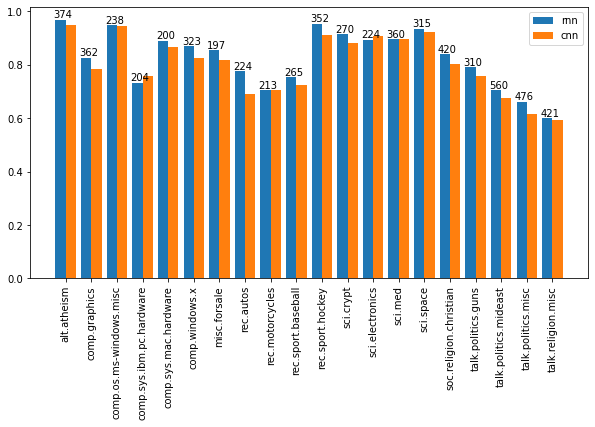

train loss:	1.719072 	valid loss:	0.751627
train loss:	0.657304 	valid loss:	0.499701
train loss:	0.310282 	valid loss:	0.428076
train loss:	0.145662 	valid loss:	0.438843
train loss:	0.085372 	valid loss:	0.418518


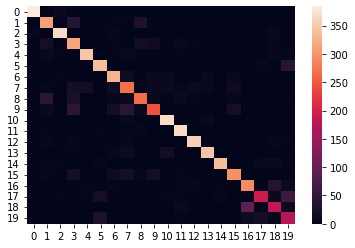

macro F1 score:	0.800224	micro F1 score:	0.807355
alt.atheism 0.9660377358490566
comp.graphics 0.7607361963190185
comp.os.ms-windows.misc 0.92
comp.sys.ibm.pc.hardware 0.72
comp.sys.mac.hardware 0.8903225806451613
comp.windows.x 0.8471177944862155
misc.forsale 0.818976279650437
rec.autos 0.67843631778058
rec.motorcycles 0.719891745602165
rec.sport.baseball 0.692090395480226
rec.sport.hockey 0.8999999999999999
sci.crypt 0.8953771289537713
sci.electronics 0.9074778200253486
sci.med 0.8911917098445595
sci.space 0.9209809264305177
soc.religion.christian 0.8065395095367848
talk.politics.guns 0.7535483870967742
talk.politics.mideast 0.6956521739130435
talk.politics.misc 0.6138279932546374
talk.religion.misc 0.6062717770034843


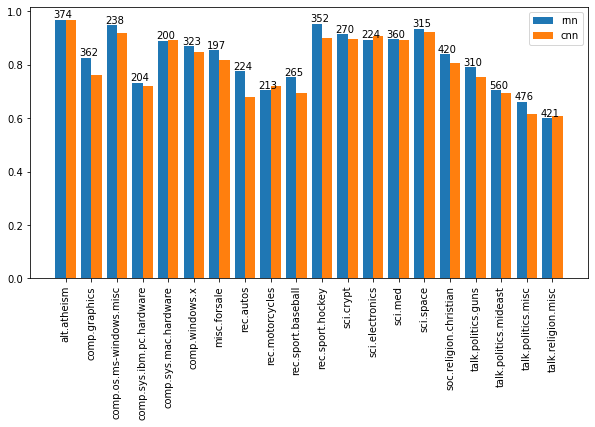

train loss:	1.737724 	valid loss:	0.772689
train loss:	0.667902 	valid loss:	0.494676
train loss:	0.318771 	valid loss:	0.415159
train loss:	0.144773 	valid loss:	0.394957
train loss:	0.072047 	valid loss:	0.403553


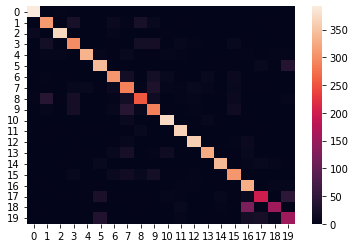

macro F1 score:	0.802351	micro F1 score:	0.810674
alt.atheism 0.9549330085261876
comp.graphics 0.7828282828282828
comp.os.ms-windows.misc 0.936868686868687
comp.sys.ibm.pc.hardware 0.7643312101910827
comp.sys.mac.hardware 0.8824306472919419
comp.windows.x 0.8295042321644498
misc.forsale 0.804177545691906
rec.autos 0.6873508353221957
rec.motorcycles 0.6967213114754098
rec.sport.baseball 0.7162329615861214
rec.sport.hockey 0.9033816425120772
sci.crypt 0.902589395807645
sci.electronics 0.9141414141414141
sci.med 0.8766756032171582
sci.space 0.9201623815967523
soc.religion.christian 0.8099606815203144
talk.politics.guns 0.7457627118644068
talk.politics.mideast 0.6970227670753065
talk.politics.misc 0.6234817813765182
talk.religion.misc 0.5984555984555985


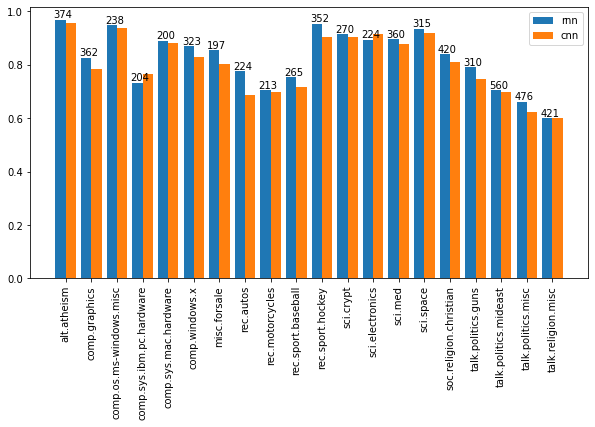

train loss:	1.701195 	valid loss:	0.762598
train loss:	0.670247 	valid loss:	0.525935
train loss:	0.316913 	valid loss:	0.419578
train loss:	0.148920 	valid loss:	0.411242
train loss:	0.072900 	valid loss:	0.384913


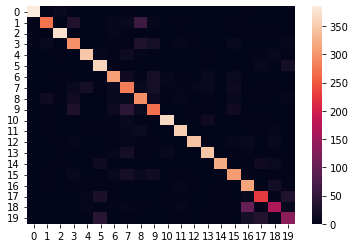

macro F1 score:	0.799285	micro F1 score:	0.806957
alt.atheism 0.9624999999999999
comp.graphics 0.7720797720797721
comp.os.ms-windows.misc 0.9373433583959898
comp.sys.ibm.pc.hardware 0.7397260273972603
comp.sys.mac.hardware 0.8854961832061069
comp.windows.x 0.8441860465116279
misc.forsale 0.8041504539559013
rec.autos 0.6650831353919239
rec.motorcycles 0.7040572792362769
rec.sport.baseball 0.7077326343381389
rec.sport.hockey 0.9219143576826196
sci.crypt 0.9001264222503161
sci.electronics 0.9086092715231787
sci.med 0.8740554156171284
sci.space 0.9047619047619047
soc.religion.christian 0.8005215123859192
talk.politics.guns 0.7508939213349225
talk.politics.mideast 0.7243589743589745
talk.politics.misc 0.6072727272727273
talk.religion.misc 0.5708245243128963


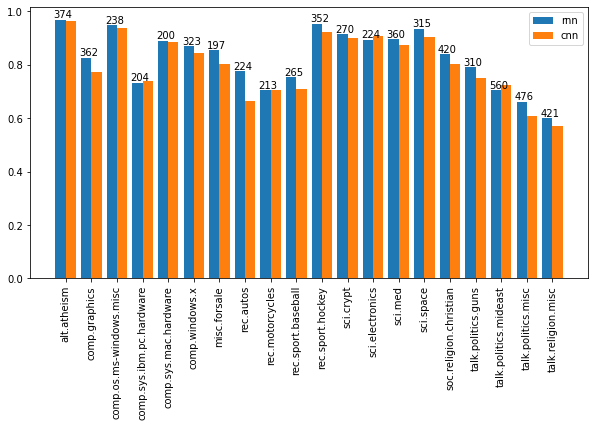

In [20]:
for _ in range(10):
  INPUT_DIM = len(TEXT.vocab)
  EMBEDDING_DIM = 100
  N_FILTERS = 100
  FILTER_SIZES = [3,4,5]
  DROPOUT = 0.5
  PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

  cnn_model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
  pretrained_embeddings = TEXT.vocab.vectors
  cnn_model.embedding.weight.data.copy_(pretrained_embeddings)
  UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
  cnn_model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
  cnn_model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)


  optimizer = optim.Adam(cnn_model.parameters(), lr=0.003)
  criterion = nn.CrossEntropyLoss()
  cnn_model = cnn_model.to(device)
  criterion = criterion.to(device)


  for epoch in range(N_EPOCHS):
      train_loss = train(cnn_model, train_iter, optimizer, criterion)
      valid_loss = evaluate(cnn_model, val_iter, criterion)
      if valid_loss < best_valid_loss:
          best_valid_loss = valid_loss
          torch.save(cnn_model.state_dict(), 'cnn.pt')
      print('train loss:\t%f'%train_loss, '\tvalid loss:\t%f'%valid_loss, )
  cnn_pre, cnn_gt = test(cnn_model, test_iter)
  confusion_m = confusion_matrix(cnn_gt, cnn_pre)
  ax = sns.heatmap(confusion_m)
  plt.show()

  plt.figure(figsize=(10,5))
  macro_s = f1_score(cnn_gt, cnn_pre, average='macro')
  micro_s = f1_score(cnn_gt, cnn_pre, average='micro')
  print('macro F1 score:\t%f\tmicro F1 score:\t%f'%(macro_s,micro_s))
  plt.bar(np.array(range(len(cats)))-0.2, f1_score(rnn_gt, rnn_pre, average=None), width=0.4, label='rnn')
  plt.bar(np.array(range(len(cats)))+0.2, f1_score(cnn_gt, cnn_pre, average=None), width=0.4, label='cnn')
  plt.xticks(list(range(len(cats))), labels=cats, rotation=90)
  plt.legend()
  for i in range(20):
    print(cats[i], f1_score(cnn_gt, cnn_pre, average=None)[i])


  lens = {}
  for _i in range(20):
    lens[_i] = [] 
  for _idx, _i in enumerate(newsgroups_test.target):
    lens[_i].append(len(newsgroups_test.data[_idx].split(' ')))
  for _i in range(20):
    lens[_i] = sum(lens[_i])/len(lens[_i])

  for _idx,(x,y) in enumerate(zip(np.array(range(len(cats)))-0.2,f1_score(rnn_gt, rnn_pre, average=None))):
      plt.text(x+0.1,y,'%i' %int(lens[_idx]), ha='center',va='bottom')
  plt.show()

In [ ]:
RNN
macro F1 score:	0.822447	micro F1 score:	0.829793
macro F1 score:	0.827171	micro F1 score:	0.834174
macro F1 score:	0.823238	micro F1 score:	0.830457
macro F1 score:	0.823688	micro F1 score:	0.829527
macro F1 score:	0.819864	micro F1 score:	0.827536
macro F1 score:	0.824752	micro F1 score:	0.830457
macro F1 score:	0.822786	micro F1 score:	0.829527
macro F1 score:	0.825052	micro F1 score:	0.831519
macro F1 score:	0.825509	micro F1 score:	0.832183
macro F1 score:	0.825179	micro F1 score:	0.832448

CNN
macro F1 score:	0.802131	micro F1 score:	0.811604
macro F1 score:	0.797135	micro F1 score:	0.802310
macro F1 score:	0.802001	micro F1 score:	0.810674
macro F1 score:	0.791448	micro F1 score:	0.797929
macro F1 score:	0.799042	micro F1 score:	0.807223
macro F1 score:	0.798614	micro F1 score:	0.806028
macro F1 score:	0.801174	micro F1 score:	0.810143
macro F1 score:	0.800224	micro F1 score:	0.807355
macro F1 score:	0.802351	micro F1 score:	0.810674
macro F1 score:	0.799285	micro F1 score:	0.806957
